# Combustion and Air Pollution HW #6

#### Consider combustion of n-heptane ($C_7H_{16}$). Heptane and air are introduced to a constant volume chamber. First let's consider $\phi$ = 1.0 and atmospheric pressure. Upon ignition, combustion of the premixed fuel/air occurs at constant volume and constant internal energy (assuming that the chamber is adiabatic).

#### Calculate:
1. The adiabatic flame temperature if the fuel and air are preheated and introduced into the chamber at 500 K. 
2. The NO mole fraction at equlibrium for $\phi$ = 0.7, 1.0, and 1.3
3. The time at which the fuel ignites for $\phi$ = 0.7, 1.0, and 1.3
4. The time at which mole fraction of the fuel drops below 100 ppm for each $\phi$
5. At what time should we quench the reaction if we want to keep NO emissions below 1000 ppm? Is this before or after the time in part (4)?

In this homework we will use more detailed combustion chemistry then we previously considered in this class, along with the Zeldovich mechanism for thermal fixation of atmospheric N2, to model and predict NOx formation in heptane combustion.
We use an open source software tool called [Cantera](http://www.cantera.org/docs/sphinx/html/index.html) which helps us solve thermodynamics and kinetics problems.

This homework was adapted from a lecture in Prof. Richard West's undergraduate chemical kinetics class in the Department of Chemical Engineering as well as existing Python notebooks in the [cantera-jupyter project](https://github.com/cantera/cantera-jupyter). 

### Simply click inside the cells below to be able to type in and edit them, and press Shift+Enter to execute the code in a cell that is selected.

In [79]:
# Imports
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import seaborn

The n-heptane ($C_7H_{16}$) mechanism we will consider is from the Lawrence Livermore National Lab (LLNL), with the 3-reaction Zeldovich mechanism manually added to it. First we create a Solution object in Cantera for n-heptane gas that includes all of the thermodynamic and kinetic parameters needed to describe its combustion. (Don't worry about the warning)

In [2]:
gas = ct.Solution('heptanesymp159.cti')



**** WARNING ****
For species c7h15o-1, discontinuity in cp/R detected at Tmid = 1391
	Value computed using low-temperature polynomial:  53.0168.
	Value computed using high-temperature polynomial: 52.748.


We can print out some chemical species and reactions that are considered in the mechanism:

In [38]:
print "Some of the species in the mechanism:"
print " ".join(gas.species_names[:20])
print "\n"

print "Model includes reactions that break down the fuel ('nc7h16'):"
for i in range(1052,1102,5):
    print gas.reaction(i)
print "\n"

print "And also contains small molecule chemistry:"
for i in range(20):
    print gas.reaction(i)
print "\n"
print "There are {0} total reactions in this mechanism!".format(len(gas.reactions()))

Some of the species in the mechanism:
n2 ch3 h ch4 h2 oh h2o o c2h6 c2h5 hco co co2 o2 h2o2 ho2 c2h4 ch3oh ch2oh ch3o


Model includes reactions that break down the fuel ('nc7h16'):
nc7h16 => c7h15-1 + h
c7h15-3 + h => nc7h16
nc7h16 => c2h5 + c5h11-1
c7h15-1 + h2 => h + nc7h16
h + nc7h16 => c7h15-4 + h2
c7h15-2 + oh => nc7h16 + o
nc7h16 + oh => c7h15-1 + h2o
c7h15-3 + h2o => nc7h16 + oh
ho2 + nc7h16 => c7h15-2 + h2o2
c7h15-4 + h2o2 => ho2 + nc7h16


And also contains small molecule chemistry:
ch3 + h (+M) => ch4 (+M)
ch4 (+M) => ch3 + h (+M)
ch4 + h => ch3 + h2
ch3 + h2 => ch4 + h
ch4 + oh => ch3 + h2o
ch3 + h2o => ch4 + oh
ch4 + o => ch3 + oh
ch3 + oh => ch4 + o
c2h6 + ch3 => c2h5 + ch4
c2h5 + ch4 => c2h6 + ch3
hco + oh => co + h2o
co + h2o => hco + oh
co + oh => co2 + h
co2 + h => co + oh
h + o2 => o + oh
o + oh => h + o2
h2 + o => h + oh
h + oh => h2 + o
h2o + o => 2 oh
2 oh => h2o + o


There are 1543 total reactions in this mechanism!


Let's look at the last few reactions in the mechanism, representing the Zeldovich mechanism.

In [4]:
zeldovich = gas.reactions()[-3:]
for rxn in zeldovich:
    print rxn.equation, rxn.rate

n + no <=> n2 + o Arrhenius(A=2.7e+10, b=0, E=1.48532e+06)
n + o2 <=> no + o Arrhenius(A=9e+06, b=1, E=2.7196e+07)
n + oh <=> h + no Arrhenius(A=3.36e+10, b=0, E=1.61084e+06)


#### 1. Calculate the adiabatic flame temperature if the fuel and air are preheated and introduced into the chamber at 500 K. 
First, we need to initialize the fuel at the correct temperature (K), pressure (Pa) and mole fractions (these can be molar ratios, Cantera will normalize them, like in STANJAN).
Replace the "xxxx" with the correct number of moles.

In [68]:
gas.TPX = 500, 1e5, 'nc7h16:1.0,o2:11.0,n2:41.58'
#gas.TPX = 1000, 1e5, 'nc7h16:1.0,o2:xxxx,n2:xxxx'

We'll find the equilibrium flame temperature by equilibrating keeping volume and internal energy
constant.

In [69]:
gas.equilibrate('UV')
print "The adiabatic flame temperature is {0} K".format(int(round(gas.T)))

The adiabatic flame temperature is 2682 K


#### 2. Calculate the NO concentration at equlibrium for $\phi$ = 0.7, 1.0, and 1.3
Change the numbers of moles for these equivalence ratios,below.

In [70]:
x_NO_stoich = gas['no'].X[0]

# For fuel lean case (0.7)
gas.TPX = 500, 1e5, 'nc7h16:1.0,o2:15.71,n2:59.4'
#gas.TPX = 1000, 1e5, 'nc7h16:1.0,o2:xxxx,n2:xxxx'
gas.equilibrate('UV')
x_NO_lean = gas['no'].X[0]

# For fuel rich case (1.3)
gas.TPX = 500, 1e5, 'nc7h16:1.0,o2:8.46,n2:31.98'
#gas.TPX = 1000, 1e5, 'nc7h16:1.0,o2:xxxx,n2:xxxx'
gas.equilibrate('UV')
x_NO_rich = gas['no'].X[0]

print "For fuel lean case, NO = {0} ppm".format(round(x_NO_lean*1e6, 1))
print "For stoichiometric case, NO = {0} ppm".format(round(x_NO_stoich*1e6, 1))
print "For fuel rich case, NO = {0} ppm".format(round(x_NO_rich*1e6, 1))

For fuel lean case, NO = 9137.0 ppm
For stoichiometric case, NO = 7226.4 ppm
For fuel rich case, NO = 1615.3 ppm


It may look like the NO is decreasing with equivalence ratio, but there is a maximum in the fuel lean region...

The NO is maximum at equivalence ratio 0.798


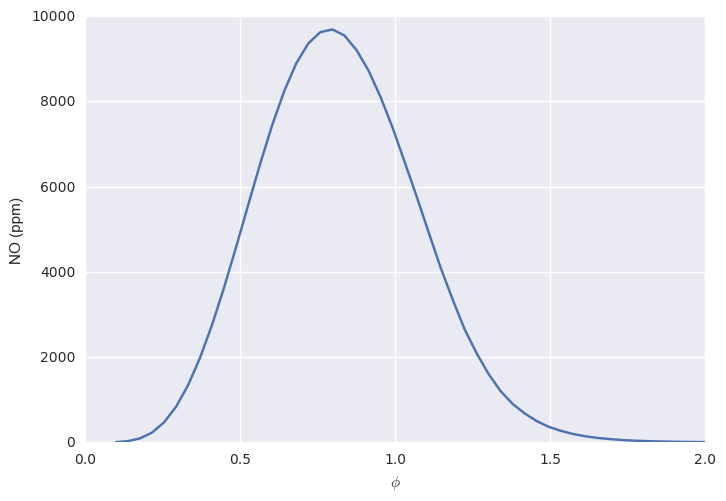

In [78]:
equivalence_ratios = np.linspace(0.1, 2, 50)
x_NO = np.zeros_like(equivalence_ratios)
for i, phi in enumerate(equivalence_ratios):
    mol_O2 = 11.0 / phi
    mol_N2 = 3.78 * mol_O2
    X_string = "nc7h16:1.0,o2:" + str(round(mol_O2, 2)) + ",n2:" + str(round(mol_N2, 2))
    gas.TPX = 500, 1e5, X_string
    gas.equilibrate('UV')
    x_NO[i] = gas['no'].X[0]
plt.plot(equivalence_ratios, x_NO*1E6)
plt.xlabel('$\phi$')
plt.ylabel('NO (ppm)')
print "The NO is maximum at equivalence ratio " + str(round(equivalence_ratios[np.argmax(x_NO)],3))

#### 3. Calculate the time at which the fuel ignites for $\phi$ = 0.7, 1.0, and 1.3
#### 4. Calculate the time at which mole fraction of the fuel drops below 100 ppm for each $\phi$
#### 5. At what time should we quench the reaction if we want to keep NO emissions below 1000 ppm? Is this before or after the time in part (4)?

For these three questions, we need to calculate kinetics.
The following code will utilize an ideal gas reactor (constant volume) in Cantera to model the reactor. We will print the answers to questions 3-5.

At equivalence ratio 0.7, fuel ignites at 71.4952 seconds
At equivalence ratio 0.7, fuel reaches 100 ppm at 71.4958 seconds
At equivalence ratio 0.7, reaction should be quenched at 71.4984 seconds


At equivalence ratio 1.0, fuel ignites at 69.4662 seconds
At equivalence ratio 1.0, fuel reaches 100 ppm at 69.4672 seconds
At equivalence ratio 1.0, reaction should be quenched at 69.4676 seconds


At equivalence ratio 1.3, fuel ignites at 68.2036 seconds
At equivalence ratio 1.3, fuel reaches 100 ppm at 68.2048 seconds
At equivalence ratio 1.3, reaction should be quenched at 68.2062 seconds




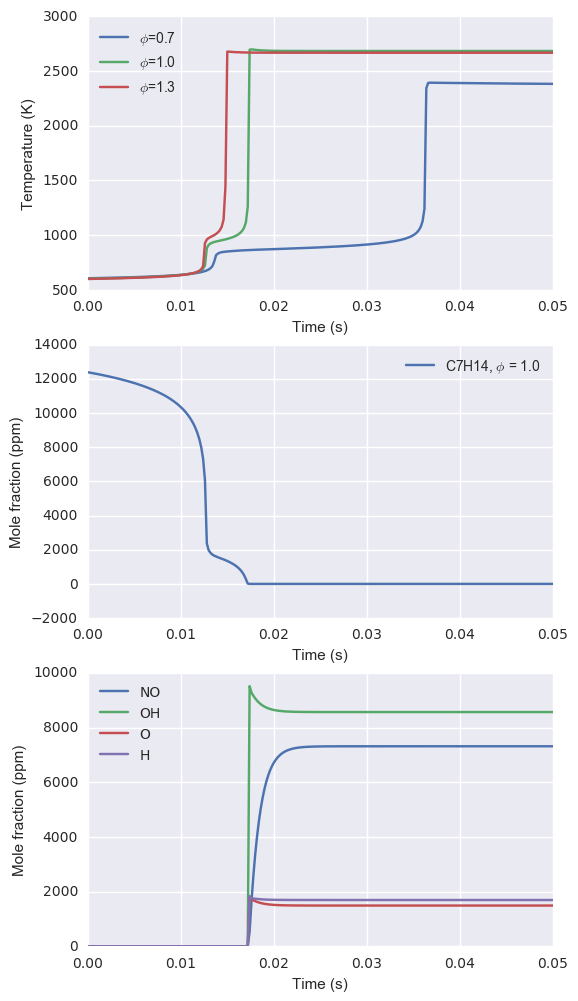

In [158]:
equivalence_ratios = np.array([0.7, 1.0, 1.3])
ignitions = np.array([71.46, 69.45, 68.19])
i_fuel = gas.species_names.index('nc7h16')
i_no = gas.species_names.index('no')
i_oh = gas.species_names.index('oh')
i_o = gas.species_names.index('o')
i_h = gas.species_names.index('h')
i_n2 = gas.species_names.index('n2')

plt.figure(figsize=(6,12))
plt_temps = plt.subplot(3,1,1)
plt_input_spec = plt.subplot(3,1,2)
plt_radicals = plt.subplot(3,1,3)

for phi, t in zip(equivalence_ratios, ignitions):
    
    mol_O2 = 11.0 / phi
    mol_N2 = 3.78 * mol_O2
    X_string = "nc7h16:1.0,o2:" + str(round(mol_O2, 2)) + ",n2:" + str(round(mol_N2, 2))
    gas.TPX = 500, 1e5, X_string

    reactor = ct.IdealGasReactor(gas)
    reactor_network = ct.ReactorNet([reactor])

    start_time = t  #starting time
    end_time = t+0.05 # seconds
    n_steps = 251
    times = np.linspace(start_time, end_time, n_steps)
    concentrations = np.zeros((n_steps, gas.n_species))
    mole_frac = np.zeros((n_steps, gas.n_species))
    pressures = np.zeros(n_steps)
    temperatures = np.zeros(n_steps)

    reached_100ppm = False
    ignited = False
    reached_NO = False

    for n, time in enumerate(times):
        if time > 0:
            reactor_network.advance(time)
        temperatures[n] = reactor.T
        pressures[n] = reactor.thermo.P
        concentrations[n,:] = reactor.thermo.concentrations
        mole_frac[n,:] = gas.X
        if reactor.T > 1000 and not ignited: # Ignition time, estimate it to be when T is above 1000 K
            ignited = True
            print "At equivalence ratio {0}, fuel ignites at {1} seconds".format(str(phi), str(round(time,6)))
        if 1e6*mole_frac[n, i_fuel] < 100.0 and not reached_100ppm: # Fuel is < 100 ppm
            reached_100ppm = True
            print "At equivalence ratio {0}, fuel reaches 100 ppm at {1} seconds".format(str(phi), str(round(time,6)))
        if 1e6*mole_frac[n, i_no] >= 1000.0 and not reached_NO: # NO is >= 1000 ppm
            reached_NO = True
            print "At equivalence ratio {0}, reaction should be quenched at {1} seconds".format(str(phi), str(round(time,6)))
            print "\n"
    
    plt_temps.plot(times-t, temperatures, label = "$\phi$=" + str(phi)) # Renormalized to just before ignition
    
    # Print other plots just for stoichiometric combustion
    if phi == 1.0:
        plt_input_spec.plot(times-t, 1E6*mole_frac[:, i_fuel], label = "C7H14, $\phi$ = 1.0")
        plt_radicals.plot(times-t, 1E6*mole_frac[:,i_no], label = "NO")
        plt_radicals.plot(times-t, 1E6*mole_frac[:,i_oh], label = "OH")
        plt_radicals.plot(times-t, 1E6*mole_frac[:,i_o], label = "O")
        plt_radicals.plot(times-t, 1E6*mole_frac[:,i_h], label = "H")
plt_temps.set_xlabel("Time (s)")
plt_temps.set_ylabel("Temperature (K)")
plt_temps.legend(loc='best')
plt_input_spec.set_xlabel("Time (s)")
plt_input_spec.set_ylabel("Mole fraction (ppm)")
plt_input_spec.legend(loc='best')
plt_radicals.set_xlabel("Time (s)")
plt_radicals.set_ylabel("Mole fraction (ppm)")
plt_radicals.legend(loc='best')

Just want to check at least one rate to make sure it's reasonably close to the one in the book...These came from the gri mech.

In [5]:
T = np.linspace(300,2500,100)

In [6]:
A = rxn.rate.pre_exponential_factor / 1000.0
n = rxn.rate.temperature_exponent
Ea = rxn.rate.activation_energy / 1000.0

In [7]:
rate_mech = A * T**n * np.exp(-Ea/8.314/T)
rate_book = 7.1E7 * np.exp(-450.0/T)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

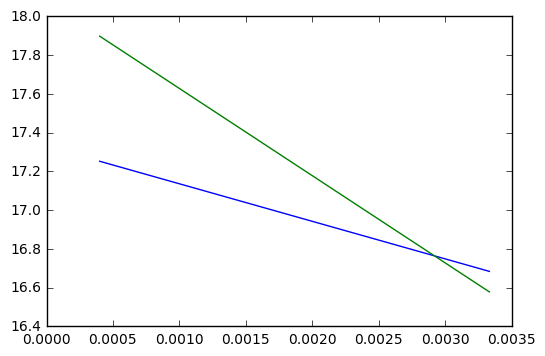

In [9]:
plt.plot(1.0/T, np.log(rate_mech))
plt.plot(1.0/T, np.log(rate_book))